In [1]:
import os

In [2]:
!pwd

/home/jovyan/notebooks/analysis/experiment_4


In [3]:
import sys
sys.path.append('/home/jovyan/')

In [4]:
from experiments.reporting.report_repository import ReportRepository
from experiments.slack_client import SlackNotifier
from neat.neat_logger import get_neat_logger
from neat.population_engine import EvolutionEngine
from neat.reporting.reports_pyneat import EvolutionReport
from neat.utils import timeit
import math
import random
from itertools import count
import numpy as np

from experiments.logger import logger
from experiments.slack_client import Notifier
from experiments.object_repository.object_repository import ObjectRepository
from experiments.reporting.report_repository import ReportPathFactory
from neat.configuration import get_configuration
from neat.evaluation.evaluation_engine import EvaluationStochasticEngine
from neat.evolution_operators.crossover import Crossover
from neat.evolution_operators.mutation import Mutation
from neat.genome import Genome
from neat.reporting.reports_pyneat import EvolutionReport
from neat.species import SpeciationEngine
from neat.stagnation import Stagnation
from neat.population_engine import PopulationEngine
from neat.utils import timeit
import neat
import tests
from config_files.configuration_utils import create_configuration
from neat.configuration import get_configuration, set_configuration
from neat.evaluation.evaluation_engine import get_dataset
from neat.evaluation.evaluate_simple import evaluate_genome, calculate_prediction_distribution
from neat.genome import Genome
from neat.evolution_operators.backprop_mutation import BackPropMutation
import os
from neat.loss.vi_loss import get_loss
import torch
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from neat.analysis.experiment_data import ExperimentDataNE, ExperimentDataNAS
from neat.analysis.uncertainty.predictive_distribution import PredictionDistributionEstimator
from neat.analysis.plotting.plot_losses import plot_loss_distribution
from neat.analysis.plotting.plot_classification_metrics import plot_metrics_by_quantile_several_executions
from neat.analysis.experiment_predictive_distributions import ExecutionsPredictionDistributions

In [7]:
LOGS_PATH = f'{os.getcwd()}/'
logger = get_neat_logger(path=LOGS_PATH)

In [14]:
config_versions = {'NE': {'project': 'neuro-evolution',
                         'algorithm_version': 'bayes-neat'},
                  'NAS': {'project': 'nas',
                         'algorithm_version': 'nas'}
                  }
datasets = ['iris', 'wine', 'breast_cancer',  'mnist_downsampled']

# datasets = ['iris', 'wine', 'breast_cancer', 'mnist_downsampled']

df_dataset_sorting = pd.DataFrame(datasets, columns=['dataset']).reset_index().rename(columns={'index': 'order'})
# df_dataset_sorting

In [15]:
version_exp_2 = 1
# version_exp_3 = 2
# version_exp_3 = 3
version_exp_4 = 1
# version_exp_3 = 5

In [16]:
chunks_ne = []
for dataset in datasets:
    try:
        data_dataset = pd.read_csv(f'./../experiment_2/data/data_experiment_2_ne_{dataset}_v{version_exp_2}.csv')
        chunks_ne.append(data_dataset)
    except:
        print('error')
    try:
        data_dataset = pd.read_csv(f'./data/data_experiment_4_ne_{dataset}_version_{version_exp_4}.csv')
        chunks_ne.append(data_dataset)
    except:
        print('error')
data_ne = pd.concat(chunks_ne)
display(data_ne.head(1))

,correlation_id,execution_id,train_percentage,noise,label_noise,is_bayesian,beta,loss_training,loss_testing,duration,...,mean_genome_std,accuracy,precision,recall,f1,ece,absolute_best,version,method,dataset
0,bayesian_neat_ft_final_v1_iris,0f5a1f1c-048b-4e92-bc72-81b00fa4041d,0.75,0.0,0.0,True,0.0001,0.59272,0.849457,0:08:55.735616,...,0.955271,97.368421,0.975232,0.973684,0.973557,0.225165,True,NE,Bayesian-NEAT,iris


In [17]:
chunks_nas = []
for dataset in datasets:
    try:
        data_dataset = pd.read_csv(f'./../experiment_2/data/data_experiment_2_nas_{dataset}_v{version_exp_2}.csv')
        chunks_nas.append(data_dataset)
    except:
        pass
    try:
        data_dataset = pd.read_csv(f'./data/data_experiment_4_nas_{dataset}_version_{version_exp_4}.csv')
        chunks_nas.append(data_dataset)
    except:
        pass
data_nas = pd.concat(chunks_nas)

# for dataset, data_dataset in data_nas.groupby('dataset'):
#     data_dataset.to_csv(f'data/data_experiment_2_nas_{dataset}.csv', index=False)

display(data_nas.head(1))

,correlation_id,execution_id,train_percentage,noise,label_noise,is_bayesian,beta,duration,end_condition,n_parameters,...,n_connections,n_layers,f1,recall,precision,accuracy,ece,version,method,dataset
0,bayesian_nas_final,04c937ef-f1f6-433c-a501-de48fd5453cf,0.75,0.0,0.0,True,0.000001,0:06:23.322305,normal,326,...,140,2,0.947169,0.947368,0.955466,94.736842,0.057842,NAS,Bayesian-MLP,iris


In [18]:
# data_ne.label_noise.unique()

In [19]:
from scipy import stats
def filter_data(data, filter_noisy=False, z_score=3):
#     data = data.loc[data['f1'] >= filter_threshold]
    chunks = []
    for _, df in data.groupby(['method', 'label_noise']):
#         df[(np.abs(stats.zscore(df['f1'])) < 3).all(axis=1)]
        df = df.loc[np.abs(stats.zscore(df['f1'])) < z_score]
        chunks.append(df)
    data = pd.concat(chunks)
    if filter_noisy:
        data = data.loc[(data['noise'] == 0) &
               (data['label_noise'] == 0)]
    
    
    return data

----
# Experiment 4

In [20]:
method_order = ['MLP', 'Bayesian-MLP', 'NEAT', 'Bayesian-NEAT']

In [21]:
data = pd.concat([data_ne, data_nas])
display(data.shape)
data = filter_data(data, filter_noisy=False, z_score=4)
data.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(1017, 25)

(1017, 25)

In [22]:
data = data.loc[data['label_noise'] <= 0.8]

In [23]:
data.loc[data['is_bayesian'] == False, 'n_parameters'] = data.loc[data['is_bayesian'] == False, 'n_parameters'] /2

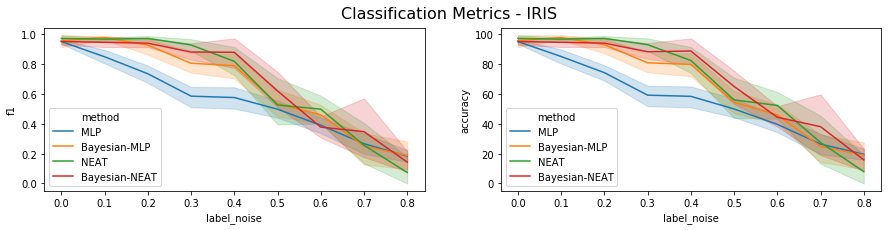

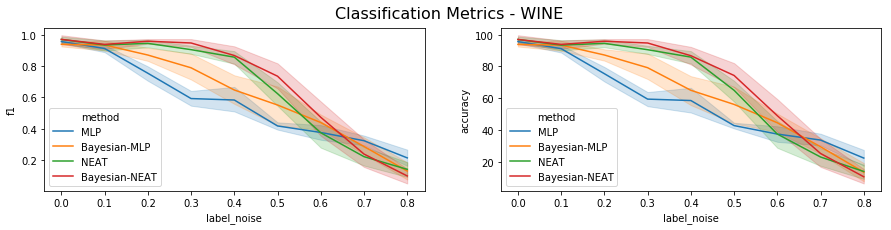

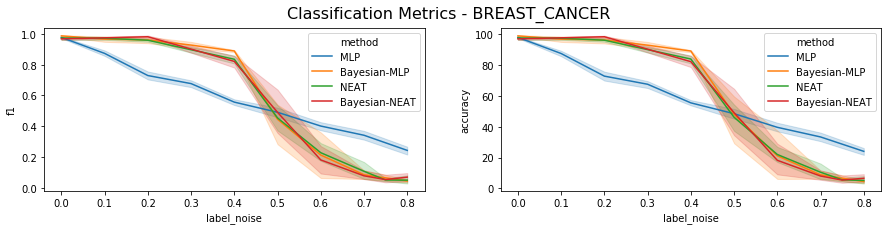

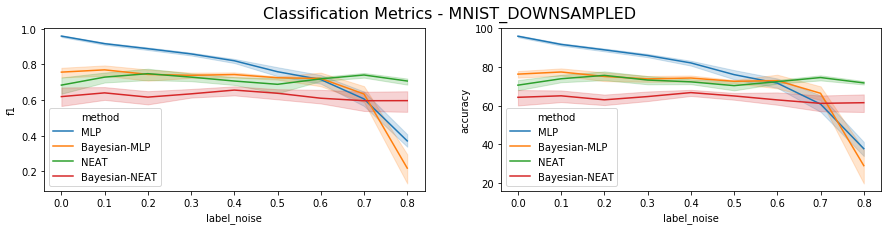

In [26]:
n_datasets = len(data['dataset'].unique())

for i, dataset in enumerate(datasets):
    data_dataset = data.loc[data['dataset'] == dataset]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle(f'Classification Metrics - {dataset.upper()}', fontsize=16)

#     sns.boxplot(data=data_dataset, x='label_noise', hue='method', y='f1', ax=ax1, hue_order=method_order)
#     sns.boxplot(data=data_dataset, x='label_noise', hue='method', y='accuracy', ax=ax2, hue_order=method_order)

    sns.lineplot(data=data_dataset, x='label_noise', hue='method', y='f1', ax=ax1, hue_order=method_order)
    sns.lineplot(data=data_dataset, x='label_noise', hue='method', y='accuracy', ax=ax2, hue_order=method_order)
    plt.savefig(f'./experiment_3_metrics_{dataset}.png')

    plt.show()